In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

import ipywidgets as widgets
from IPython.display import display
import pickle


import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

import zuko
import lampe.inference
import lampe.utils
from tqdm.notebook import tqdm_notebook as tqdm
from lampe.utils import GDStep

from itertools import islice
from lampe.data import JointLoader

c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
theta_true = torch.Tensor([0])
prior = torch.distributions.Normal(0, 5)
N=100

# True Posteriors

## Observing 2 random variable $ z_1, z_2 \sim \mathcal{N}(\theta, 1) $

In [3]:

#Say we observe z1, z2
zi = torch.distributions.Normal(theta_true, 1).sample((N,)).squeeze().tolist()
z1, z2 = zi[0], zi[1]

In [4]:

def posterior_z(thetas, z1=z1, z2=z2):
    """Posterior if we observe z1, z2"""
    def improper_posterior_z(theta, z1=z1, z2=z2):
        likelihood_part = -(np.square(theta-z1) + np.square(theta-z2))/2
        prior_part = np.square(theta)/50
        res = np.exp(likelihood_part)*np.exp(prior_part)
        return res
    Z_z1_z2, eps = integrate.quad(improper_posterior_z,-15,15) #Integral of p_impropre(θ|z1,z2)
    return [improper_posterior_z(theta,z1,z2)/Z_z1_z2 for theta in thetas]
    return improper_posterior_z(theta, z1, z2)/Z_z1_z2


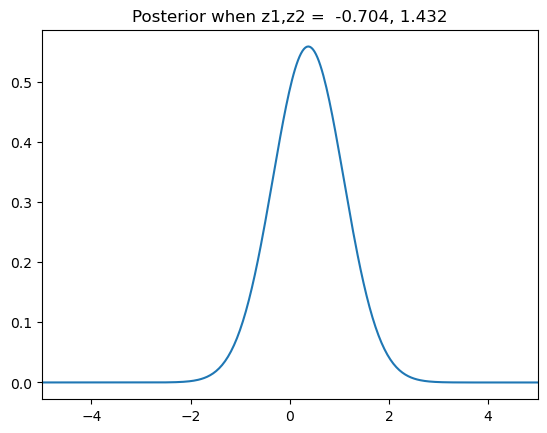

In [5]:
theta_grid = np.linspace(-15,15,1000)
eval_post = posterior_z(theta_grid, z1, z2)
fig = plt.figure()
plt.plot(theta_grid, eval_post)
plt.xlim(left=-5,right=5)
plt.title(f"Posterior when z1,z2 =  {z1:.3f}, {z2:.3f}")
plt.show()

## Say we observed the mean of two random variables, $x= \frac{1}{2}(z_1 + z_2) $

In [6]:
x = (z1 + z2)/2

In [7]:
def posterior_x(thetas, x=x):
    """Posterior when observing x=mean(z1, z2)"""
    def improper_posterior_x(theta, x=x):
        likelihood_part = -np.square(theta - x)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x, eps = integrate.quad(improper_posterior_x, -15, 15)
    return [improper_posterior_x(theta,x)/z_x for theta in thetas]

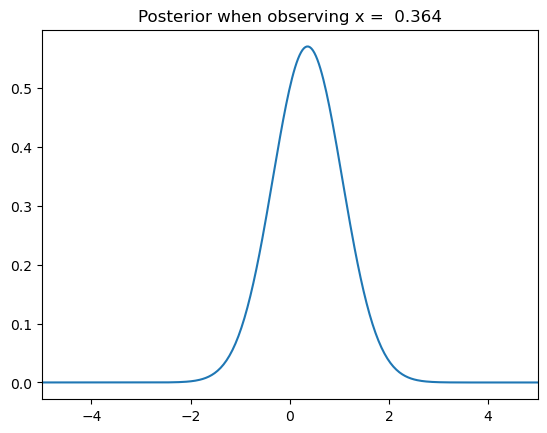

In [8]:
eval_post_x = posterior_x(theta_grid, x)
fig = plt.figure()
plt.plot(theta_grid, eval_post_x)
plt.xlim(left=-5,right=5)
plt.title(f"Posterior when observing x =  {x:.3f}")
plt.show()

## Say we observed the mean of N random variables

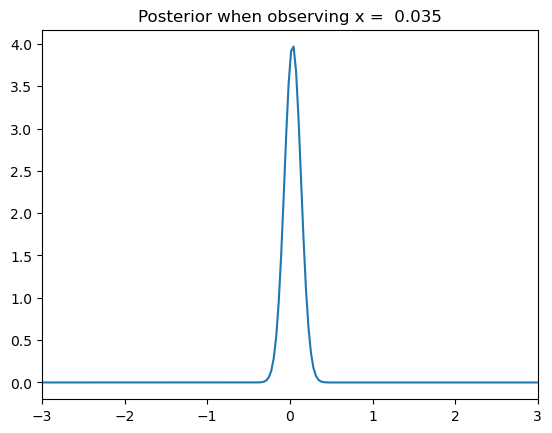

In [9]:
x = np.mean(zi)


def posterior_x_N(thetas, x=x):
    """Posterior when observing x= mean(z1, z2... ,zn)"""
    def impropoer_posterior_x_N(theta, x=x):
        likelihood_part = -N*np.square(theta -x)/2
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x_n, eps = integrate.quad(impropoer_posterior_x_N,-15, 15)
    
    return [impropoer_posterior_x_N(theta,x)/z_x_n for theta in thetas]



eval_post_x_n = posterior_x_N(theta_grid, x) 
fig = plt.figure()
plt.plot(theta_grid, eval_post_x_n)
plt.title(f"Posterior when observing x =  {x:.3f}")
plt.xlim(left=-3,right=3)
plt.show()

## Suppose we observed the mean and the variance of N random variables

In [10]:
x1 = np.mean(zi)
x2 = np.var(zi)
np.abs(x1 - theta_true)

tensor([0.0347])

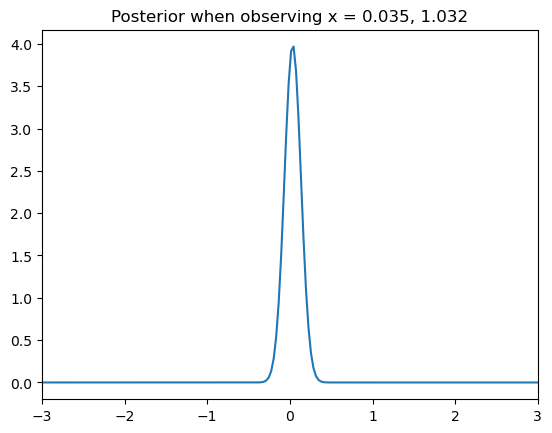

In [11]:
def posterior_summaries(thetas, x1=x1, x2=x2):
    """Posterior when observing x= mean(z1...zn), var(z1...zn)"""
    def impropoer_posterior_summaries(theta,x1=x1,x2=x2):
        likelihood_x1_part = -N*np.square(theta - x1)/2
        likelihood_x2_part = -N*np.square(1 - x2)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_x1_part)*np.exp(likelihood_x2_part)*np.exp(prior_part)+1e-9
    z_summaries, eps = integrate.quad(impropoer_posterior_summaries, -25, 25)
    return [impropoer_posterior_summaries(theta,x1,x2)/z_summaries for theta in thetas]
    return impropoer_posterior_summaries(theta,x1,x2)/z_summaries

eval_post_summaries = posterior_summaries(theta_grid, x1, x2)
fig = plt.figure()
plt.plot(theta_grid, eval_post_summaries)
plt.title(f"Posterior when observing x = {x1:.3f}, {x2:.3f}")
plt.xlim(left=-3,right=3)
plt.show()

## Suppose we observed the variance of N random variables

In [12]:
x=np.var(zi)

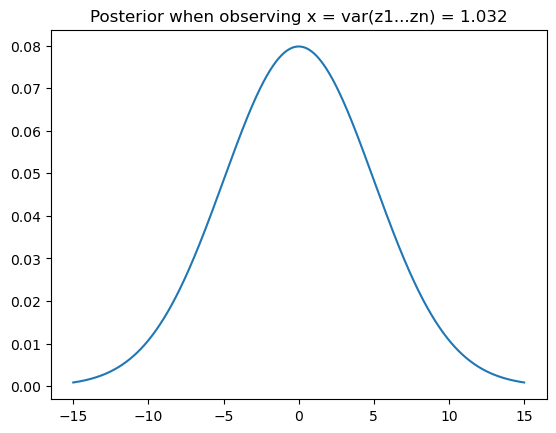

In [13]:
def posterior_var(thetas, x=x):
    """Posterior when observing x= var(z1...zn)"""
    def improper_posterior_var(theta,x=x):
        likelihood_part = -N*np.square(x-1)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_summaries, eps = integrate.quad(improper_posterior_var, -25, 25)
    return [improper_posterior_var(theta,x)/z_summaries for theta in thetas]
    return improper_posterior_var(theta,x)/z_summaries

eval_post_var= posterior_var(theta_grid, x2)
fig = plt.figure()
plt.plot(theta_grid, eval_post_var)
plt.title(f"Posterior when observing x = var(z1...zn) = {x2:.3f}")
#plt.xlim(left=-3,right=3)
plt.show()

## Comparaison

c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\matplotlib\cbook\__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


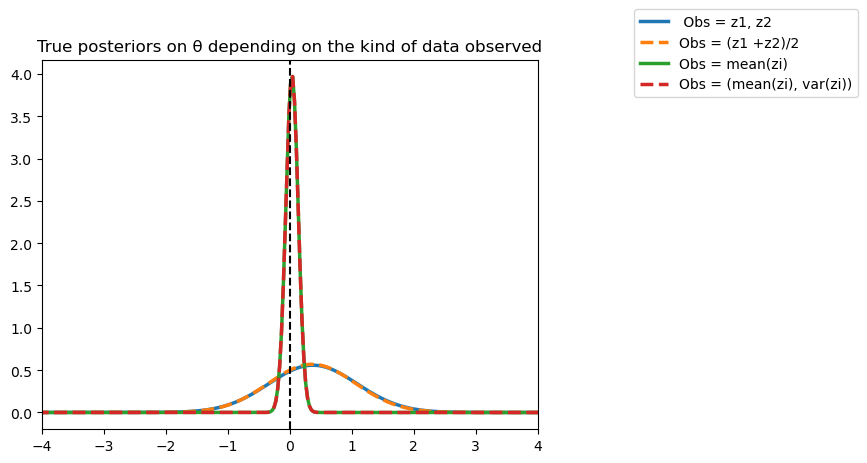

In [14]:
fig = plt.figure()
plt.xlim(left=-4, right=4)
plt.plot(theta_grid, eval_post, label=" Obs = z1, z2", linewidth=2.5)
plt.plot(theta_grid, eval_post_x, label="Obs = (z1 +z2)/2", linestyle='dashed', linewidth=2.5)
plt.plot(theta_grid, eval_post_x_n, label="Obs = mean(zi)", linewidth=2.5)
plt.plot(theta_grid, eval_post_summaries, label="Obs = (mean(zi), var(zi))", linestyle="dashed", linewidth=2.5)
#plt.plot(theta_grid, eval_post_var, label="Obs = var(zi)", linewidth=2.5)
plt.axvline(x=theta_true, ls='--', c='k')
fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("True posteriors on θ depending on the kind of data observed")
plt.show()


As expected the last 2 methods yield similar results

In [15]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [123]:
def get_true_post(summaries, x_star):
    theta_grid_t = torch.tensor(theta_grid)#.to(device)  # Convert theta_grid to a torch tensor and move to device
    print("HERE \n")
    if "two_z" == summaries:
        # We observe z1, z2
        post = posterior_z(theta_grid_t, x_star[0], x_star[1]) 
        dist = posterior_z
    elif "mean_two_z" == summaries:
        # We observed x = mean(z1, z2)
        post = posterior_x(theta_grid_t, x_star) 
        dist = posterior_x
    elif "var" == summaries:
        # We observe x = var(z1...zn)
        post = posterior_var(theta_grid_t, x_star) 
        dist = posterior_var
    elif "var" in summaries and "mean" in summaries:
        # We observe x = (x1, x2) = (mean, var)
        post = posterior_summaries(theta_grid_t, x_star[0], x_star[1]) 
        dist = posterior_summaries
    elif "mean" == summaries:
        # We observe x = mean(z1, ... z100)
        post = posterior_x_N(theta_grid_t, x_star)
        dist = posterior_x_N

    post = torch.stack(post).to(device)  # Move post to device
    return post, dist


# Now let us compare these true posteriors to the estimations using SBI

Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

 Neural network successfully converged after 12 epochs.

C:\Users\mmmat\AppData\Local\Temp\ipykernel_18924\2621513431.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


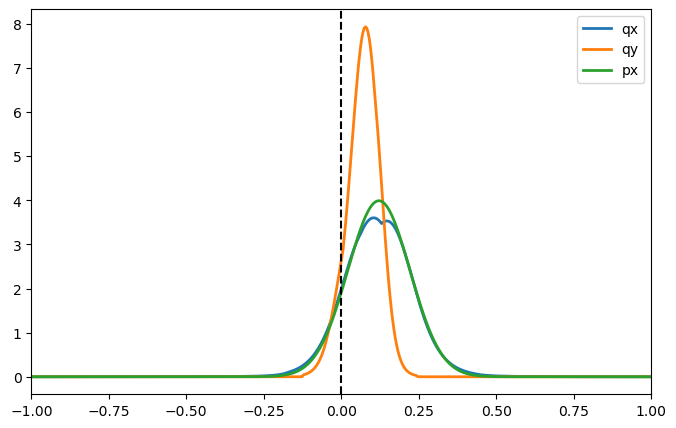

In [17]:


torch.manual_seed(42)

# define the prior over theta
prior = torch.distributions.Normal(
    loc=torch.tensor([0.0]), scale=torch.tensor([5.0])
)

# define the model to work with
def gaussian(theta, sigma, summ_stats):
    zx = torch.distributions.Normal(loc=theta, scale=sigma).sample((100,))
    sx = {}
    sx['mean'] = zx.mean()
    sx['var'] = zx.var()
    sx['raw'] = zx[0]
    sx['mean_two_realisations'] = torch.distributions.Normal(loc=theta, scale=sigma).sample((2,)).mean()
    ss = []
    for st in summ_stats:
        ss.append(sx[st])
    
    return torch.tensor(ss)

# choose which summary statistics to consider
ss = ['mean', 'var']

# fix the standard deviations of the zx
sigma_x = 1.0

# make sure that prior and model are in SBI format
simulator, prior = prepare_for_sbi(
    partial(gaussian, sigma=sigma_x, summ_stats=ss),
    prior)

# instantiate the density estimator to use
density_estimator_build_fun = posterior_nn(
    model="nsf",
    hidden_features=40,
    num_transforms=5,
    num_bins=10,
    num_blocks=2
)

# instantiate an inference object
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)

# generate the training dataset with simulations
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=50_000)
# store the simulations in the inference object
inference = inference.append_simulations(theta, x)

# train the neural spline flow on the simulated data
density_estimator = inference.train(training_batch_size=256,
                                    stop_after_epochs=5,
                                    max_num_epochs=50,
                                    learning_rate=5e-4,
                                    validation_fraction=0.10)

# build the posterior estimator object
posterior = inference.build_posterior(density_estimator)

# choose the ground truth value of the input parameter
mu = torch.tensor([0.0]).view(1,-1)

# generate observations
x = gaussian(theta=mu, sigma=sigma_x, summ_stats=ss)

sigma_y = np.sqrt(2)
y = gaussian(theta=mu, sigma=sigma_y, summ_stats=ss)

# generate samples via rejection sampling
tt = torch.linspace(-2, 2, 1000).view(-1, 1)
qx = torch.exp(posterior.log_prob(tt, x=x))
qy = torch.exp(posterior.log_prob(tt, x=y))

tt = np.linspace(-2, +2, 1000)
px = np.exp(-50*(tt - x[0].item())**2) * np.exp(-tt**2/50)
dt = tt[1] - tt[0]
Z = np.sum(px * dt)
px = px / Z

fig, ax = plt.subplots(figsize=(8, 5))
bins = torch.linspace(-2, +2, 100)
dx = bins[1] - bins[0]
ax.plot(tt, qx, lw=2.0, c='C0', label='qx')
ax.plot(tt, qy, lw=2.0, c='C1', label='qy')
ax.plot(tt, px, lw=2.0, c='C2', label='px')
ax.axvline(x=mu.item(), ls='--', c='k')
ax.set_xlim([-1, +1])
ax.legend()
fig.show()

In [36]:
import torch
import torch.distributions as distributions
import numpy as np
from tqdm import tqdm

def generate_data(thetas, sigma_y_2=1):
    N = thetas.shape[0]
    res = {}
    device = thetas.device
    means = torch.zeros((N, 1)).to(device)
    means_two_z = torch.zeros((N, 1)).to(device)
    means_and_vars = torch.zeros((N, 2)).to(device)
    vars = torch.zeros((N, 1)).to(device)
    raws = torch.zeros((N, 1)).to(device)
    two_z_l = torch.zeros((N, 2)).to(device)
    
    with tqdm(thetas, unit='theta', leave=False, desc="Generating data") as tq:
        for i, theta in enumerate(tq):
            z = distributions.Normal(theta, 1).sample((100,)).to(device)
            mean = z.mean()
            var = z.var()
            z0, z1 = z[0], z[1]
            mean_two_z = torch.mean(torch.stack([z0, z1]))
            
            means[i] = mean
            means_two_z[i] = mean_two_z.unsqueeze_(0)
            means_and_vars[i] = torch.stack([mean.unsqueeze_(0), var.unsqueeze_(0)]).squeeze_()
            two_z_l[i] = torch.stack([z0, z1]).squeeze_()
            vars[i] = var
            raws[i] = z0
            
    res["mean"] = {"x": means}
    res["mean_two_z"] = {"x": means_two_z}
    res["mean_and_var"] = {"x": means_and_vars}
    res["two_z"] = {"x": two_z_l}
    res["raw_z"] = {"x": raws}
    res["var"] = {"x": vars}
    
    for key in res.keys():
        epsilons = distributions.Normal(torch.zeros_like(res[key]["x"]), np.sqrt(sigma_y_2)).sample().to(device)
        res[key]["eps"] = epsilons
        
    return res


In [19]:
M = 20_000 #TODO A changer + tard

## Observing the mean $ x = \frac{1}{N} \sum_{i=1}^{N}{z_i}$

In [20]:
def build_nsf(features, context):
    """Callable to instantiate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5).to(device)

def train_flow(flow, loss, theta, x, theta_test, x_test):
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    data = lampe.data.JointDataset(theta.to(device), x.to(device))
    loader = lampe.data.DataLoader(data, 256)
    
    with torch.no_grad():
        min_loss = loss(theta_test.to(device), x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar
    
    flow.train()

    with tqdm(range(50), unit='epoch', leave=False, desc="Training NPE") as tq:
        for epoch in tq:
            for theta_batch, x_batch in loader:
                theta_batch = theta_batch.to(device)
                x_batch = x_batch.to(device)
                losses = loss(theta_batch, x_batch)
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
            
            # Checking for early stopping
            with torch.no_grad():
                loss_test = loss(theta_test.to(device), x_test.to(device))
                min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
                if len(min_loss_list) - np.argmin(min_loss_list) > 5: # No improvement in loss(test) for the last 5 iterations
                    # Early stop  
                    tq.close()
                    break
            tq.set_postfix(loss=loss_test.item())
    flow.eval()
    return flow


nsf = lampe.inference.NPE(theta_dim=1, x_dim=1, build=build_nsf).to(device)
loss = lampe.inference.NPELoss(nsf).to(device)
theta = prior.sample((M, )).to(device)
theta_test = prior.sample((M//10, )).to(device)
data = generate_data(theta)
data_test = generate_data(theta_test)
x = data["mean"]["x"].to(device)
x_test = data_test["mean"]["x"].to(device)
nsf = train_flow(nsf, loss, theta, x, theta_test, x_test)


In [21]:
x_star = generate_data(theta_true, 1)["mean"]["x"].to(device)  # Suppose we observe one x=mean(sample) where sample~N(θ|1)
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,)).cpu()


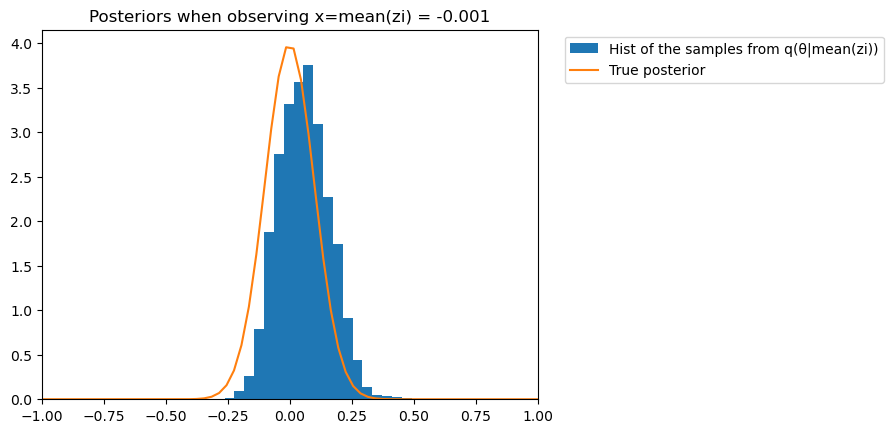

In [22]:
plt.hist(samples.squeeze_().numpy(), density=True, bins=200, label="Hist of the samples from q(θ|mean(zi))")
x_star.squeeze_()
true_post_summaries = posterior_x_N(theta_grid, x_star.cpu().numpy()) 
plt.plot(theta_grid, true_post_summaries, label="True posterior")
plt.xlim(left=-1, right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(zi) = {x_star.item():.3f}")
plt.show()

## When taking the observed mean and variance as summaries : $$x = (x_1, x_2),\\ x_1=\frac{1}{N}\sum_{i=1}^{N}{zi} \\ x_2 = \frac{1}{N}\sum_{i=1}^N{\left( z_i-x_1 \right) }^2$$

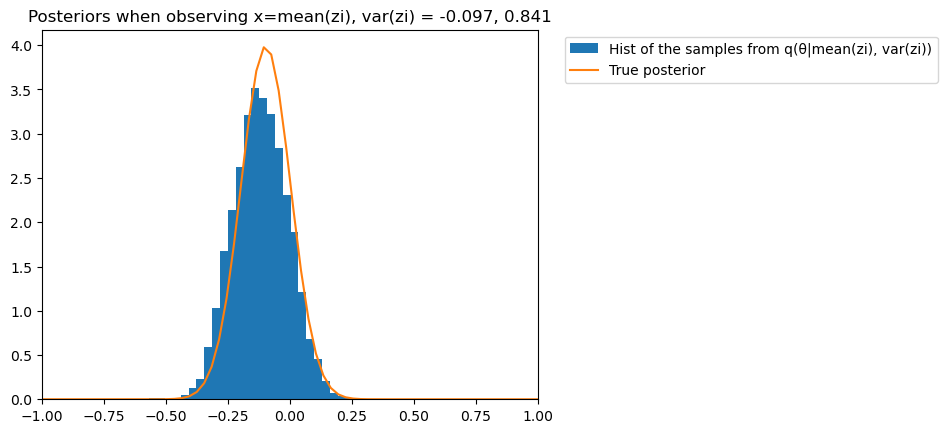

In [23]:
nsf = lampe.inference.NPE(theta_dim=1, x_dim=2, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
x = data["mean_and_var"]["x"].to(device)
x_test = data_test["mean_and_var"]["x"].to(device)
nsf = train_flow(nsf, loss, theta, x, theta_test, x_test)

x_star = generate_data(theta_true, 1)["mean_and_var"]["x"].to(device)
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,)).cpu()
x_star.squeeze_()
plt.hist(samples.squeeze_().numpy(), density=True, bins=200, label="Hist of the samples from q(θ|mean(zi), var(zi))")
eval_post_summaries = posterior_summaries(theta_grid, x_star[0].item(), x_star[1].item())
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-1, right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(zi), var(zi) = {x_star[0].item():.3f}, {x_star[1].item():.3f}")
plt.show()


## Observing the mean $ x = \frac{1}{2} \left( z_1 + z_2 \right)$

In [24]:
nsf = lampe.inference.NPE(theta_dim=1, x_dim=1, build=build_nsf).to(device)
loss = lampe.inference.NPELoss(nsf).to(device)

x = data["mean_two_z"]["x"].to(device)
x_test = data_test["mean_two_z"]["x"].to(device)
nsf = train_flow(nsf, loss, theta, x, theta_test, x_test)

x_star = generate_data(theta_true, 1)["mean_two_z"]["x"].to(device)
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,)).cpu()
x_star.squeeze_()


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

tensor(0.2751, device='cuda:0')

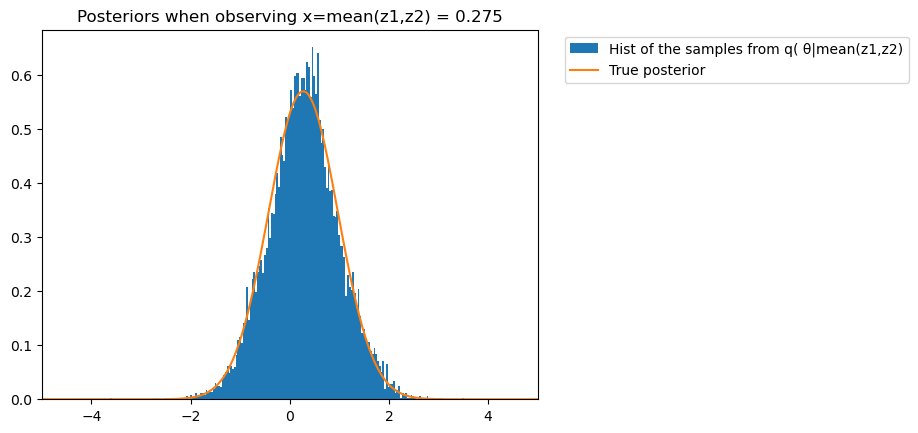

In [25]:
plt.hist(samples.squeeze_().numpy(), density=True, bins=200, label="Hist of the samples from q( θ|mean(z1,z2)")
eval_post_summaries = posterior_x(theta_grid, x_star.item())
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-5,right=5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(z1,z2) = {x_star.item():.3f}")
plt.show()

## Observing two realisations $ z_1,z_2$

In [26]:
nsf = lampe.inference.NPE(theta_dim=1, x_dim=2, build=build_nsf).to(device)
loss = lampe.inference.NPELoss(nsf).to(device)

x = data["two_z"]["x"].to(device)
x_test = data_test["two_z"]["x"].to(device)
nsf = train_flow(nsf, loss, theta, x, theta_test, x_test)


In [27]:
x_star = generate_data(theta_true, 1)["two_z"]["x"].to(device)
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,)).cpu()
x_star.squeeze_()


tensor([ 0.4978, -0.3331], device='cuda:0')

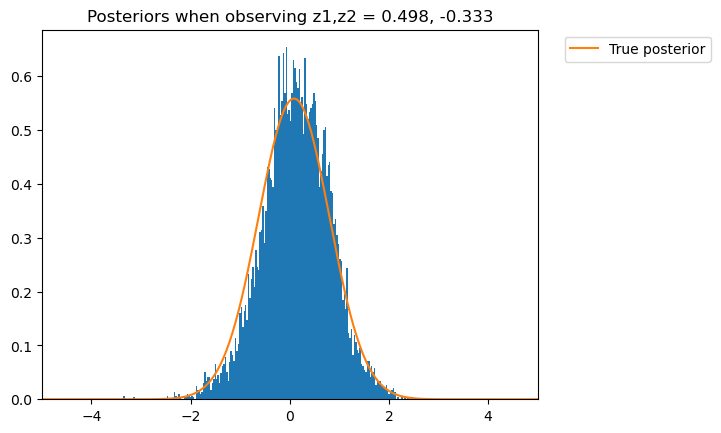

In [28]:
plt.hist(samples.squeeze_().numpy(),density=True, bins=200)
eval_post_summaries = posterior_z(theta_grid, x_star[0].item(), x_star[1].item())
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-5,right=5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing z1,z2 = {x_star[0].item():.3f}, {x_star[1].item():.3f}")
plt.show()

In [125]:
def create_train_flow(summaries,theta,x,theta_test,x_test):
    shape_x = lambda x: 2 if x=="mean_and_var" or x=="two_z" else 1
    flow = lampe.inference.NPE(theta_dim= 1, x_dim=shape_x(summaries) , build=build_nsf)
    loss = lampe.inference.NPELoss(flow)
    flow = train_flow(flow, loss, theta, x, theta_test, x_test)
    return flow
def eval(flow, summaries, theta_star, sigma_y_2):
    data_star = generate_data(theta_star, sigma_y_2)
    x_star = data_star[summaries]["x"].to(device)
    y_star = data_star[summaries]["eps"].to(device) + x_star
    flow.eval()
    # Getting samples from the trained flow
    print(y_star)
    with torch.no_grad():
        samples = flow.sample(x_star, (10_000,)).squeeze().to('cpu').numpy()
        samples_y = flow.sample(y_star, (10_000,)).squeeze().to('cpu').numpy()
    _, true_post_dist_y = get_true_post(summaries, y_star.squeeze().to('cpu').numpy())
    return x_star.squeeze_().cpu(), y_star.squeeze_().cpu(), samples, samples_y, true_post_dist_y


In [126]:


def get_posterior(summaries, flow, theta_star, sigma_y_2):
    x_star, y_star, samples, samples_y, true_post_dist_y = eval(flow, summaries, theta_star, sigma_y_2)
    # Convert NumPy arrays to PyTorch tensors

    # Getting the true posterior
    print(x_star.device)
    true_post_density, true_post_dist = get_true_post(summaries, x_star)

    _, true_post_dist_y = get_true_post(summaries, y_star.squeeze())

    return true_post_density, samples, samples_y, true_post_dist, true_post_dist_y


In [127]:
def compute_distances(samples_true_distribution, flow_samples):
    #samples_true_distribution = mcmc(true_density,10_000)
    mu_true_distribution = np.mean(samples_true_distribution)
    std_true_distribution = np.std(samples_true_distribution)
    
    flow_mean = np.mean(flow_samples)#.item()
    flow_std = np.std(flow_samples)#.item()
    
    distance = np.square(mu_true_distribution - flow_mean) + np.square(np.log(std_true_distribution/flow_std))
    return torch.tensor(distance).cuda()

In [128]:
def prepare_ax_posteriors(sigma_2):
    plt.close()
    sigma_y_2 = (sigma_2 - 1)
    summaries = ["two_z", "mean_two_z", "mean", "mean_and_var", "var"]
    fig, ax = plt.subplots(3, 2, figsize=(10, 10))
    i = 0

    true_posts = {}
    samples_x = {}
    samples_y = {}
    true_dists = {}
    true_post_dists_y = {}
    distances = {}
    theta = prior.sample((M,)).to(device)
    theta_test = prior.sample((M // 10,))
    data = generate_data(theta, sigma_y_2)
    data_test = generate_data(theta_test, sigma_y_2)
    
    with tqdm(summaries, unit='summary statistic', leave=False, desc="Summaries") as tq:
        for summary in tq:
            distances[summary] = {}
            tq.set_postfix(summary=summary)
            distances_qx_l  = torch.zeros((10,)).to(device)
            distances_qy_l = torch.zeros((10,)).to(device)
            flow = create_train_flow(summary, theta, data[summary]["x"].to(device), theta_test, data_test[summary]["x"].to(device))
            with tqdm(range(10), unit="run", leave=False, desc="Computing distances") as tq_i:
                for j in tq_i:
                    true_post, samples, sample_y, true_post_dist, true_post_dist_y = get_posterior(summary, flow, theta_true, sigma_y_2)
                    distances_qx_l[j] = compute_distances(true_post.cpu().numpy(), samples)
                    distances_qy_l[j] = compute_distances(true_post.cpu().numpy(), sample_y)
                tq_i.update()
            distances[summary]["x"] = torch.mean(distances_qx_l).item()
            distances[summary]["y"] = torch.mean(distances_qy_l).item()
            row = i // 2
            col = i % 2
            
            hist1 = ax[row, col].hist(samples, density=True, bins=200, label="SBI Posterior q(θ|x)", alpha=0.80)
            ax[row, col].plot(theta_grid, true_post.cpu(), label="True posterior p(θ|x)")
            hist2 = ax[row, col].hist(sample_y, density=True, bins=200, label="SBI Posterior q(θ|y)", alpha=0.5)
            ax[row, col].axvline(x=theta_true, ls='--', c='k')
            ax[row, col].set_title(f"using {summary} as summary")
            
            lower_bound = min(np.min(samples).item(), np.min(sample_y).item()) - 2
            upper_bound = max(np.max(samples), np.max(sample_y)) + 2

            ax[row, col].set_xlim(lower_bound, upper_bound)
            ax[row, col].legend()
            
            i += 1
            samples_x[summary] = samples
            samples_y[summary] = sample_y
            true_posts[summary] = true_post
            true_dists[summary] = true_post_dist
            true_post_dists_y[summary] = true_post_dist_y
    
    fig.suptitle(f"Posteriors with sigma² = {sigma_2}")
    return fig, distances


In [129]:
M=50_000

In [130]:
results = {}
#sigmas_2 = [1,2,3,4]
sigmas_2 = np.arange(1,5,0.5)
with tqdm(sigmas_2, unit='Sigma', desc="Sigmas") as tq:
    for sigma_2 in tq:
        results[sigma_2] = {}
        tq.set_postfix({"sigma²":sigma_2})
        results[sigma_2]["figure"], results[sigma_2]["distances"] = prepare_ax_posteriors(sigma_2)
        plt.close()

Sigmas:   0%|          | 0/8 [00:00<?, ?Sigma/s, sigma²=1]
































tensor([[-0.2128,  1.0009]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.2235,  0.7693]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.4557, -0.9514]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.2754, -1.4998]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1040,  0.7984]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.9210, 0.9878]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 1.0010, -1.0458]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 2.1072, -0.2359]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.8239, -0.5427]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.5526, 1.3773]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\matplotlib\cbook\__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)







































tensor([[1.1337]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.6811]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.7846]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.3176]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.2009]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  50%|█████     | 5/10 [00:02<00:01,  2.50run/s]





tensor([[0.1126]], device='cuda:0')
HERE 

cpu


HERE 

HERE 



tensor([[-0.2018]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.6949]], device='cuda:0')
HERE 

cpu


HERE 

HERE 



Computing distances:  80%|████████  | 8/10 [00:03<00:00,  2.59run/s]





tensor([[-0.6876]], device='cuda:0')
HERE 





Computing distances:  90%|█████████ | 9/10 [00:03<00:00,  2.44run/s]

cpu
HERE 

HERE 



tensor([[-0.1503]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.0374]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0673]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.0752]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.2009]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1572]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0198]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.0244]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1262]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.0878]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1080]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0165, 1.0876]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1017,  1.0188]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  20%|██        | 2/10 [00:01<00:04,  1.67run/s]





tensor([[-0.0504,  1.0105]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  30%|███       | 3/10 [00:01<00:04,  1.66run/s]





tensor([[0.0360, 0.8890]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.1222, 1.1838]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0511, 0.7751]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  60%|██████    | 6/10 [00:03<00:02,  1.62run/s]





tensor([[0.0515, 0.8975]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0129,  1.0181]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0402,  1.0044]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:05<00:00,  1.67run/s]





tensor([[-0.0167,  0.9039]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.9660]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2756]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.1302]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.8200]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.9742]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  50%|█████     | 5/10 [00:01<00:01,  3.24run/s]





tensor([[0.9181]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.7769]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  70%|███████   | 7/10 [00:02<00:01,  2.66run/s]





tensor([[0.6619]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.7865]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.7563]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Sigmas:  12%|█▎        | 1/8 [01:28<10:18, 88.30s/Sigma, sigma²=1.5]


































tensor([[0.7532, 0.1554]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.3057, 1.7737]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.1150, 1.5442]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 1.9227, -2.2065]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.7830, -1.0739]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 1.1019, -0.0081]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 1.6233, -1.7147]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.0419, -1.0787]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.9846, -1.4074]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.1285, 1.5289]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.1933]], device='cuda:0')
HERE 



cpu
HERE 

HERE 



tensor([[2.8926]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[2.6055]], device='cuda:0')
HERE 

cpu


HERE 

HERE 



Computing distances:  30%|███       | 3/10 [00:01<00:02,  2.56run/s]





tensor([[0.8215]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-3.0965]], device='cuda:0')
HERE 

cpu


HERE 

HERE 



Computing distances:  50%|█████     | 5/10 [00:01<00:01,  2.60run/s]





tensor([[-1.4680]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.8969]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  70%|███████   | 7/10 [00:02<00:01,  2.57run/s]





tensor([[0.9978]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  80%|████████  | 8/10 [00:03<00:00,  2.59run/s]





tensor([[0.5561]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:03<00:00,  2.43run/s]





tensor([[1.3348]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances: 100%|██████████| 10/10 [00:03<00:00,  2.47run/s]























tensor([[0.2687]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.3774]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.3477]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8649]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.9005]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1838]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.2709]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2022]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.6806]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.8632]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0230,  0.4790]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.0779, 1.1873]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.0487, 1.6724]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.2212, 0.2987]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.3171, 1.4051]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.4210, 1.7685]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4029, 0.2361]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.5619,  0.6768]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 0.5736, -0.2674]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.2815, 2.4883]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.1080]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.2390]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  20%|██        | 2/10 [00:00<00:02,  3.10run/s]





tensor([[1.7988]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.5704]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  40%|████      | 4/10 [00:01<00:01,  3.11run/s]





tensor([[1.1877]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0536]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.2149]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  70%|███████   | 7/10 [00:02<00:00,  3.12run/s]





tensor([[1.6537]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  80%|████████  | 8/10 [00:02<00:00,  3.13run/s]





tensor([[1.2298]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.4876]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





Sigmas:  25%|██▌       | 2/8 [03:08<09:31, 95.25s/Sigma, sigma²=2]  








































tensor([[2.5477, 0.0996]], device='cuda:0')
HERE 

cpu
HERE 





Computing distances:  10%|█         | 1/10 [00:00<00:05,  1.75run/s]

HERE 



tensor([[1.9018, 2.5432]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.1157, 1.2747]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.0720, 1.2753]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0318, 0.1273]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.3236, -0.2293]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-1.1779,  2.4277]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.5850, 1.0319]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.4211, -0.1441]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.2517,  1.5622]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.0054]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.0796]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.9877]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.0909]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.4946]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0803]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.6857]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0462]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.6640]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.2248]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1217]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1365]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1054]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1973]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.1618]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.3448]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.3530]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2231]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.9394]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5137]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.9169,  1.3293]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.4521,  0.2248]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.8975,  1.1676]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.6274,  1.1392]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.9523,  2.3334]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  50%|█████     | 5/10 [00:03<00:03,  1.37run/s]





tensor([[0.1506, 0.7110]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.9923, 3.5665]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2168, 0.8997]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  80%|████████  | 8/10 [00:06<00:01,  1.24run/s]





tensor([[-0.2113,  1.2114]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.8776, -1.3014]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.6512]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.3379]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.2761]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.6601]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8648]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.3468]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2524]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.7824]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4952]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4085]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





Sigmas:  38%|███▊      | 3/8 [05:42<10:09, 121.94s/Sigma, sigma²=2.5]






















































tensor([[0.5296, 1.5765]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.4580,  4.2501]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-1.8259,  1.8926]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-2.5753, -0.6896]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 0.8777, -0.8258]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[4.3833, 1.2052]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.2437,  2.8707]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5687,  1.2973]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.5083, 0.4068]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:06<00:00,  1.44run/s]





tensor([[-0.6934,  2.5752]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1188]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-3.1706]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.6528]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[2.2532]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.2640]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.7337]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5794]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.5732]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.2232]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.5969]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.0409]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2983]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.1312]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.6045]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.2694]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.2394]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1044]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.8403]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.4394]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1146]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.8787, 3.4733]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.4644,  1.4480]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  20%|██        | 2/10 [00:01<00:06,  1.31run/s]





tensor([[ 0.7437, -0.4397]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  30%|███       | 3/10 [00:02<00:05,  1.35run/s]





tensor([[-1.2534,  0.1169]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  40%|████      | 4/10 [00:02<00:04,  1.40run/s]





tensor([[ 1.6632, -0.3983]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.1265, 0.2601]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.4685, -1.7046]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  70%|███████   | 7/10 [00:05<00:02,  1.34run/s]





tensor([[-0.3127,  0.8194]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8667, 0.4552]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:06<00:00,  1.28run/s]





tensor([[1.9435, 2.6209]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances: 100%|██████████| 10/10 [00:07<00:00,  1.30run/s]



































tensor([[2.6098]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.4807]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.6070]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8541]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2714]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.8877]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.0399]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.6992]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.5288]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.6187]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





Sigmas:  50%|█████     | 4/8 [08:08<08:45, 131.41s/Sigma, sigma²=3]  






































tensor([[ 2.8197, -0.7886]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 1.9908, -1.5783]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.9738, 0.4196]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.9320, -0.8651]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.7979, 1.8290]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.7477, -0.6426]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.3748, 0.7213]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 0.2754, -0.5597]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.5354,  0.4394]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.9467, 0.0849]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0356]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.2126]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5854]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.1737]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.0716]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.2024]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2488]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4700]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.1714]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.7604]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.9677]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.4133]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.8761]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4261]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5724]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.3475]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.5252]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.0747]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.5486]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.2110]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2616, 0.0886]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.6097, 0.8592]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  20%|██        | 2/10 [00:01<00:05,  1.39run/s]





tensor([[1.8518, 0.1399]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0068, -2.2632]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  40%|████      | 4/10 [00:02<00:04,  1.33run/s]





tensor([[1.1621, 2.5555]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0853, 3.1842]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.1279, 0.5223]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  70%|███████   | 7/10 [00:05<00:02,  1.33run/s]





tensor([[1.0649, 0.6026]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.3033, 0.7348]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:06<00:00,  1.31run/s]





tensor([[ 1.1031, -0.0294]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances: 100%|██████████| 10/10 [00:07<00:00,  1.34run/s]









































tensor([[2.2040]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.0474]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.7297]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.3290]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.0548]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.2286]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[2.1738]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.5235]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[2.3295]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.8283]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





Sigmas:  62%|██████▎   | 5/8 [10:46<07:03, 141.28s/Sigma, sigma²=3.5]






























tensor([[2.5832, 0.7826]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.9437, 1.1183]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-1.8536,  0.8915]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5225,  2.7738]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-3.0128, -4.9942]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-1.4640, -4.6230]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5736, -0.6723]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.9045, 1.0269]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.0610, -2.3856]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-3.1210, -0.2870]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.6880]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.2750]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.3278]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.7687]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.7773]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0625]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.1556]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.4080]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.6844]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2273]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8448]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.8751]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.1013]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.1273]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.2858]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4360]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1512]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4286]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.1678]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.8384]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.5642, 1.5221]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.5898, 2.0919]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  20%|██        | 2/10 [00:01<00:05,  1.36run/s]





tensor([[1.6206, 2.0509]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  30%|███       | 3/10 [00:02<00:05,  1.36run/s]





tensor([[-0.3321, -0.8417]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  40%|████      | 4/10 [00:02<00:04,  1.37run/s]





tensor([[-0.9308,  1.9117]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  50%|█████     | 5/10 [00:03<00:03,  1.35run/s]





tensor([[-1.0963,  2.9236]], device='cuda:0')
HERE 

cpu
HERE 





Computing distances:  60%|██████    | 6/10 [00:04<00:03,  1.31run/s]

HERE 



tensor([[-0.0268, -1.0057]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  70%|███████   | 7/10 [00:05<00:02,  1.34run/s]





tensor([[-0.2710, -0.8019]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.9747, 0.4941]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:06<00:00,  1.34run/s]





tensor([[ 1.5356, -1.3225]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances: 100%|██████████| 10/10 [00:07<00:00,  1.33run/s]





























tensor([[-0.2491]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.1568]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  20%|██        | 2/10 [00:00<00:02,  2.72run/s]





tensor([[-0.3964]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.0572]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.4959]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.3868]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.4492]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.5755]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.8786]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2913]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





Sigmas:  75%|███████▌  | 6/8 [12:42<04:25, 132.66s/Sigma, sigma²=4]  






















tensor([[3.6434, 0.6694]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.4816, -1.6769]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.4989,  1.0830]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.0435, -1.8086]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.2021, -1.4809]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.0489, 2.5131]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 0.7936, -0.0349]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.9695, -1.4824]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-3.2973,  4.8266]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.7592,  4.4651]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.9664]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.1290]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.9864]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5661]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.3549]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1367]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.1680]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.3734]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.0315]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.7972]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8948]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.7411]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4194]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.9978]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.5809]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.2403]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.0762]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.4428]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.2559]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.6486]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.7611,  0.8462]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.4416, -0.3482]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8149, 0.0751]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[4.0967, 3.3179]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  40%|████      | 4/10 [00:02<00:04,  1.39run/s]





tensor([[0.2511, 0.5794]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  50%|█████     | 5/10 [00:03<00:03,  1.35run/s]





tensor([[-0.6268, -0.6072]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.5572, -0.3870]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.8099, -1.7963]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  80%|████████  | 8/10 [00:05<00:01,  1.37run/s]





tensor([[-0.6375,  1.9424]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:06<00:00,  1.33run/s]





tensor([[0.9958, 0.6458]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances: 100%|██████████| 10/10 [00:07<00:00,  1.38run/s]

































tensor([[1.9655]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.9683]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1621]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.6967]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.2731]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[0.1714]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[2.0775]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.2358]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.0632]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8140]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





Sigmas:  88%|████████▊ | 7/8 [14:52<02:11, 131.65s/Sigma, sigma²=4.5]


























tensor([[ 2.9937, -2.0026]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 1.0862, -2.2694]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-3.7929, -3.3920]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0083,  3.4132]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.0426, -2.2474]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[1.3818, 2.9157]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[ 3.6458, -2.1914]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.6067, -0.1881]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.4362, 0.2384]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-1.2262,  0.5537]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-3.4351]], device='cuda:0')
HERE 



cpu
HERE 

HERE 



Computing distances:  10%|█         | 1/10 [00:00<00:04,  2.09run/s]





tensor([[-5.0613]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.1415]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.8804]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.8233]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1092]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.3781]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8482]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.7089]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.1195]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1170]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.3397]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-1.1770]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8894]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-2.7101]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.7096]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.2508]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.7482]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[1.8342]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.5010]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.7398,  0.0641]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  10%|█         | 1/10 [00:00<00:06,  1.33run/s]





tensor([[ 0.8820, -0.3405]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  20%|██        | 2/10 [00:01<00:06,  1.31run/s]





tensor([[3.3323, 5.6695]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  30%|███       | 3/10 [00:02<00:05,  1.32run/s]





tensor([[ 0.5846, -1.3488]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.0687, 0.9410]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[ 0.3494, -0.6369]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  60%|██████    | 6/10 [00:04<00:03,  1.26run/s]





tensor([[-1.0381, -2.1765]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  70%|███████   | 7/10 [00:05<00:02,  1.31run/s]





tensor([[-0.0036,  0.1252]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  80%|████████  | 8/10 [00:06<00:01,  1.31run/s]





tensor([[ 3.4967, -3.3377]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances:  90%|█████████ | 9/10 [00:06<00:00,  1.33run/s]





tensor([[0.0049, 2.0977]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



Computing distances: 100%|██████████| 10/10 [00:07<00:00,  1.34run/s]

































tensor([[5.5292]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.5527]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[2.5452]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.2688]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[-0.0674]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.1751]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[3.9977]], device='cuda:0')
HERE 

cpu
HERE 



HERE 



tensor([[-0.3182]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[0.8598]], device='cuda:0')
HERE 

cpu
HERE 

HERE 



tensor([[3.1488]], device='cuda:0')
HERE 

cpu
HERE 

HERE 





Sigmas: 100%|██████████| 8/8 [17:50<00:00, 133.79s/Sigma, sigma²=4.5]


In [131]:
sigmas_2 = np.arange(1,5,0.5)

In [133]:
@widgets.interact(sigma_2=sigmas_2)
def plot_posteriors_widget(sigma_2=1):
    plt.close()
    return results[sigma_2]["figure"]

interactive(children=(Dropdown(description='sigma_2', options=(1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5), value=…

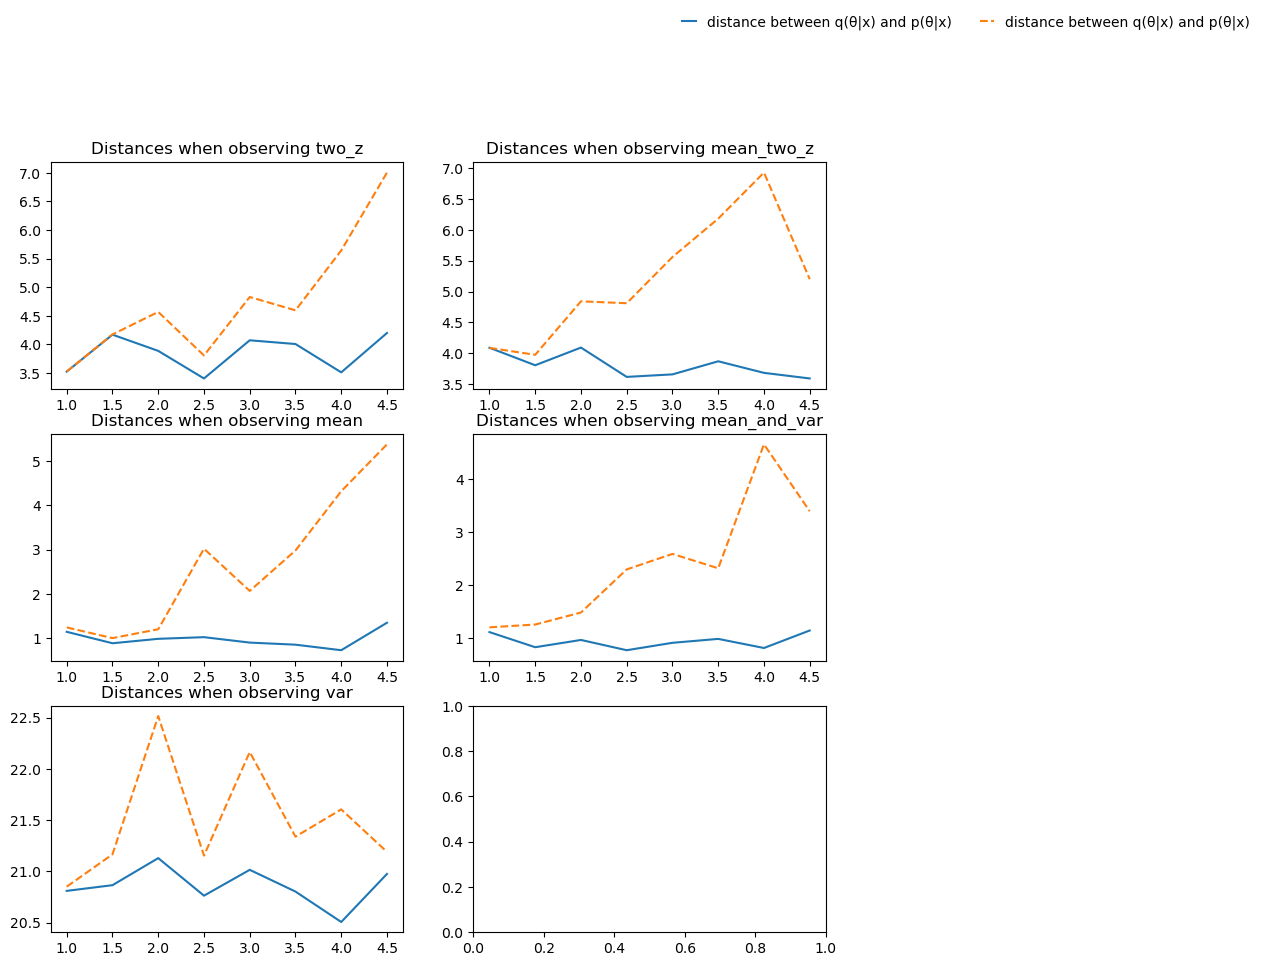

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))
i=0
for summary in results[1]["distances"].keys():
    row = i // 2  
    col = i % 2 
    distances_x = [results[sigma_2]["distances"][summary]["x"] for sigma_2 in results.keys()]
    distances_y = [results[sigma_2]["distances"][summary]["y"] for sigma_2 in results.keys()]
    ax[row][col].plot(results.keys(), distances_x, label="distance between q(θ|x) and p(θ|x)")
   
    ax[row][col].plot(results.keys(), distances_y,linestyle='dashed',label="distance between q(θ|x) and p(θ|x)")
    ax[row][col].set_title(f"Distances when observing {summary}")
   
    i+=1
labels = ["distance between q(θ|x) and p(θ|x)", "distance between q(θ|x) and p(θ|x)"]
fig.legend(labels, loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(1.04, 1), prop={'size': 10}, facecolor='white', handlelength=1.0, handleheight=1.0)
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

# RNPE

In [ ]:
np.save("0906",results)